Greetings!!!

This is my first attempt ever to publish or work with data using Python (I'm a completely beginner in both Python or Data Science).

As this is a new field for me, I was advised to replicate some of the already done work, thus I would at least have a starting point so well an ending point.

To do so I decided to translate one of the R kernels to Python. This kernel is based on "The Top 20 Football Players" which was done by Eryk Walczak (https://www.kaggle.com/erykwalczak/top-20-football-players).

You'll probably have better way to do things than how I am doing. In this case, I'd be glad to get advices and suggestions and I'll try to update and improve the code.



----------
Future features that I would like to add:

 1. Improve boxplot displays
 2. Improve heatmap for correlation matrix
 3. Progress with SVD decomposition to check which attributes are more relevant to classify top players
 4. ...


----------


In [1]:
#%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import sqlite3
from scipy import linalg, optimize

As a start, I'm reading in the table of Players and Player's Attributes, they are assigned respectively to player and player_att pandas data frame.

In [2]:
with sqlite3.connect('../input/database.sqlite') as con:
    player = pd.read_sql_query('SELECT * from Player', con)
    player_att = pd.read_sql_query('SELECT * from Player_Attributes', con)

Then I merge both data frames based on the player_api_id feature that is equal to both tables.

In [3]:
player_merged = player_att.merge(player, left_on = 'player_api_id', right_on = 'player_api_id', how = 'inner')

In [4]:
player_merged.head()

,id_x,player_fifa_api_id_x,player_api_id,date,overall_rating,potential,preferred_foot,attacking_work_rate,defensive_work_rate,crossing,...,gk_handling,gk_kicking,gk_positioning,gk_reflexes,id_y,player_name,player_fifa_api_id_y,birthday,height,weight
0,1,218353,505942,2016-02-18 00:00:00,67.0,71.0,right,medium,medium,49.0,...,11.0,10.0,8.0,8.0,1,Aaron Appindangoye,218353,1992-02-29 00:00:00,182.88,187
1,2,218353,505942,2015-11-19 00:00:00,67.0,71.0,right,medium,medium,49.0,...,11.0,10.0,8.0,8.0,1,Aaron Appindangoye,218353,1992-02-29 00:00:00,182.88,187
2,3,218353,505942,2015-09-21 00:00:00,62.0,66.0,right,medium,medium,49.0,...,11.0,10.0,8.0,8.0,1,Aaron Appindangoye,218353,1992-02-29 00:00:00,182.88,187
3,4,218353,505942,2015-03-20 00:00:00,61.0,65.0,right,medium,medium,48.0,...,10.0,9.0,7.0,7.0,1,Aaron Appindangoye,218353,1992-02-29 00:00:00,182.88,187
4,5,218353,505942,2007-02-22 00:00:00,61.0,65.0,right,medium,medium,48.0,...,10.0,9.0,7.0,7.0,1,Aaron Appindangoye,218353,1992-02-29 00:00:00,182.88,187


Then I sort by date the merged data frame which I kept with the name of player_att. As you can see there are several repeated rows for the same player, so I just keep the most up-to-date.

In [5]:
player_merged = player_merged.sort_values('date')
player_merged = player_merged.drop_duplicates('player_api_id', keep = 'last')

In [6]:
player_merged.head()

,id_x,player_fifa_api_id_x,player_api_id,date,overall_rating,potential,preferred_foot,attacking_work_rate,defensive_work_rate,crossing,...,gk_handling,gk_kicking,gk_positioning,gk_reflexes,id_y,player_name,player_fifa_api_id_y,birthday,height,weight
144773,144774,174009,359194,2007-08-30 00:00:00,56.0,70.0,right,None,_0,34.0,...,23.0,40.0,23.0,23.0,8692,Quini,174009,1985-10-29 00:00:00,180.34,159
80570,80571,150550,33688,2007-08-30 00:00:00,66.0,74.0,right,None,_0,25.0,...,67.0,65.0,64.0,73.0,4853,Jeremy Gavanon,150550,1983-09-20 00:00:00,182.88,163
115891,115892,8038,30597,2008-08-30 00:00:00,68.0,76.0,right,None,o,69.0,...,22.0,73.0,22.0,22.0,6955,Martijn Meerdink,8038,1976-09-15 00:00:00,180.34,172
140697,140698,152782,97463,2008-08-30 00:00:00,67.0,69.0,right,None,o,72.0,...,25.0,59.0,25.0,25.0,8430,Paulinho,152782,1983-08-24 00:00:00,172.72,148
52951,52952,165767,114671,2008-08-30 00:00:00,64.0,75.0,right,None,o,47.0,...,22.0,51.0,22.0,22.0,3169,Fabiano Oliveira,165767,1987-03-16 00:00:00,182.88,172


I don't really like the fact that I'm sorting this data twice, for the date first and then for the overall_rating, but I don't know yet how to make this selection smarter.

In [7]:
player_merged = player_merged.sort_values('overall_rating', ascending = False)
player_merged.head()

,id_x,player_fifa_api_id_x,player_api_id,date,overall_rating,potential,preferred_foot,attacking_work_rate,defensive_work_rate,crossing,...,gk_handling,gk_kicking,gk_positioning,gk_reflexes,id_y,player_name,player_fifa_api_id_y,birthday,height,weight
102482,102483,158023,30981,2015-12-17 00:00:00,94.0,94.0,left,medium,low,80.0,...,11.0,15.0,14.0,8.0,6176,Lionel Messi,158023,1987-06-24 00:00:00,170.18,159
33330,33331,20801,30893,2015-10-16 00:00:00,93.0,93.0,right,high,low,82.0,...,11.0,15.0,14.0,11.0,1995,Cristiano Ronaldo,20801,1985-02-05 00:00:00,185.42,176
131464,131465,190871,19533,2016-02-04 00:00:00,90.0,94.0,right,high,medium,72.0,...,9.0,15.0,15.0,11.0,7867,Neymar,190871,1992-02-05 00:00:00,175.26,150
105983,105984,176580,40636,2015-10-16 00:00:00,90.0,90.0,right,high,medium,77.0,...,25.0,31.0,33.0,37.0,6377,Luis Suarez,176580,1987-01-24 00:00:00,182.88,187
109033,109034,167495,27299,2016-04-21 00:00:00,90.0,90.0,right,medium,medium,15.0,...,87.0,91.0,90.0,87.0,6556,Manuel Neuer,167495,1986-03-27 00:00:00,193.04,203


The first step is to remove NaN entries, for some players there the attributes are NaN as can be seen bellow.

In [8]:
player_merged.loc[pd.isnull(player_merged['overall_rating'])]

,id_x,player_fifa_api_id_x,player_api_id,date,overall_rating,potential,preferred_foot,attacking_work_rate,defensive_work_rate,crossing,...,gk_handling,gk_kicking,gk_positioning,gk_reflexes,id_y,player_name,player_fifa_api_id_y,birthday,height,weight
141160,141161,193767,178196,2013-09-20 00:00:00,NaN,NaN,None,None,None,NaN,...,NaN,NaN,NaN,NaN,8462,Pavel Sultes,193767,1985-09-15 00:00:00,180.34,170
51008,51009,117343,41308,2013-09-20 00:00:00,NaN,NaN,None,None,None,NaN,...,NaN,NaN,NaN,NaN,3059,Eric Hassli,117343,1981-05-03 00:00:00,193.04,201
129797,129798,200529,110189,2016-03-17 00:00:00,NaN,NaN,None,None,None,NaN,...,NaN,NaN,NaN,NaN,7768,Nacer Chadli,148581,1989-08-02 00:00:00,187.96,176


In [9]:
player_merged.dropna(how = 'any', inplace = True)
player_merged.head()

,id_x,player_fifa_api_id_x,player_api_id,date,overall_rating,potential,preferred_foot,attacking_work_rate,defensive_work_rate,crossing,...,gk_handling,gk_kicking,gk_positioning,gk_reflexes,id_y,player_name,player_fifa_api_id_y,birthday,height,weight
102482,102483,158023,30981,2015-12-17 00:00:00,94.0,94.0,left,medium,low,80.0,...,11.0,15.0,14.0,8.0,6176,Lionel Messi,158023,1987-06-24 00:00:00,170.18,159
33330,33331,20801,30893,2015-10-16 00:00:00,93.0,93.0,right,high,low,82.0,...,11.0,15.0,14.0,11.0,1995,Cristiano Ronaldo,20801,1985-02-05 00:00:00,185.42,176
131464,131465,190871,19533,2016-02-04 00:00:00,90.0,94.0,right,high,medium,72.0,...,9.0,15.0,15.0,11.0,7867,Neymar,190871,1992-02-05 00:00:00,175.26,150
105983,105984,176580,40636,2015-10-16 00:00:00,90.0,90.0,right,high,medium,77.0,...,25.0,31.0,33.0,37.0,6377,Luis Suarez,176580,1987-01-24 00:00:00,182.88,187
109033,109034,167495,27299,2016-04-21 00:00:00,90.0,90.0,right,medium,medium,15.0,...,87.0,91.0,90.0,87.0,6556,Manuel Neuer,167495,1986-03-27 00:00:00,193.04,203


In [10]:
dont_keep_attr = ['id_x', 'player_fifa_api_id_x', 'player_api_id', 'date', 'id_y', 'player_fifa_api_id_y', 'birthday', 'preferred_foot', 'attacking_work_rate', 'defensive_work_rate', 'player_name']
attr_list = [att for att in player_merged if att not in dont_keep_attr]
print(attr_list)



['overall_rating', 'potential', 'crossing', 'finishing', 'heading_accuracy', 'short_passing', 'volleys', 'dribbling', 'curve', 'free_kick_accuracy', 'long_passing', 'ball_control', 'acceleration', 'sprint_speed', 'agility', 'reactions', 'balance', 'shot_power', 'jumping', 'stamina', 'strength', 'long_shots', 'aggression', 'interceptions', 'positioning', 'vision', 'penalties', 'marking', 'standing_tackle', 'sliding_tackle', 'gk_diving', 'gk_handling', 'gk_kicking', 'gk_positioning', 'gk_reflexes', 'height', 'weight']


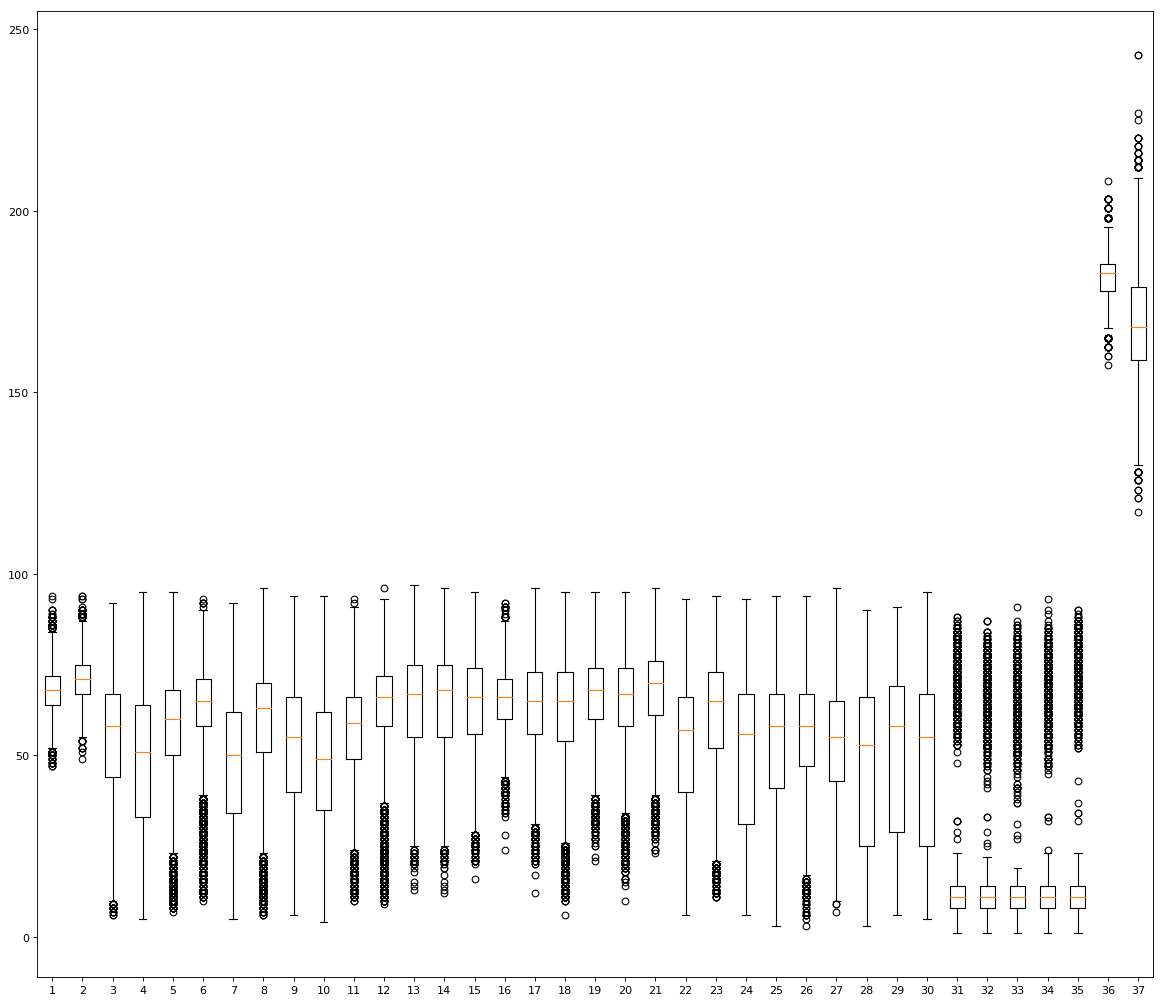

In [11]:
plt.figure(figsize = (18, 16), dpi = 80, facecolor = 'w', edgecolor = 'k')
#plt.figure(figsize = (12, 10))
data_to_plot = [np.array(player_merged[att]) for att in attr_list]
plt.boxplot(data_to_plot)
plt.show()

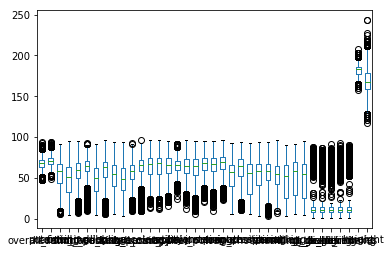

In [12]:
#plt.figure(figsize = (18, 16), dpi = 80, facecolor = 'w', edgecolor = 'k')
#plt.figure(figsize = (12, 10))
data_to_plot = [np.array(player_merged[att]) for att in attr_list]
player_merged[attr_list].plot(kind = 'box')
plt.figure(figsize = (18, 16), dpi = 80, facecolor = 'w', edgecolor = 'k')
plt.show()

The box plot above is not very clarifying, thus I will split the attributes into small set of groups.

In [13]:
set1 = ['overall_rating', 'potential']
set2 = ['crossing', 'finishing', 'heading_accuracy', 'short_passing', 'volleys', 'dribbling', 'curve', 'free_kick_accuracy', 'long_passing', 'ball_control', 'acceleration', 'sprint_speed', 'agility', 'reactions', 'balance', 'shot_power', 'jumping', 'stamina', 'strength', 'long_shots', 'aggression', 'interceptions', 'positioning', 'vision', 'penalties', 'marking', 'standing_tackle', 'sliding_tackle']
set3 = ['gk_diving', 'gk_handling', 'gk_kicking', 'gk_positioning', 'gk_reflexes']
set4 = ['height', 'weight']

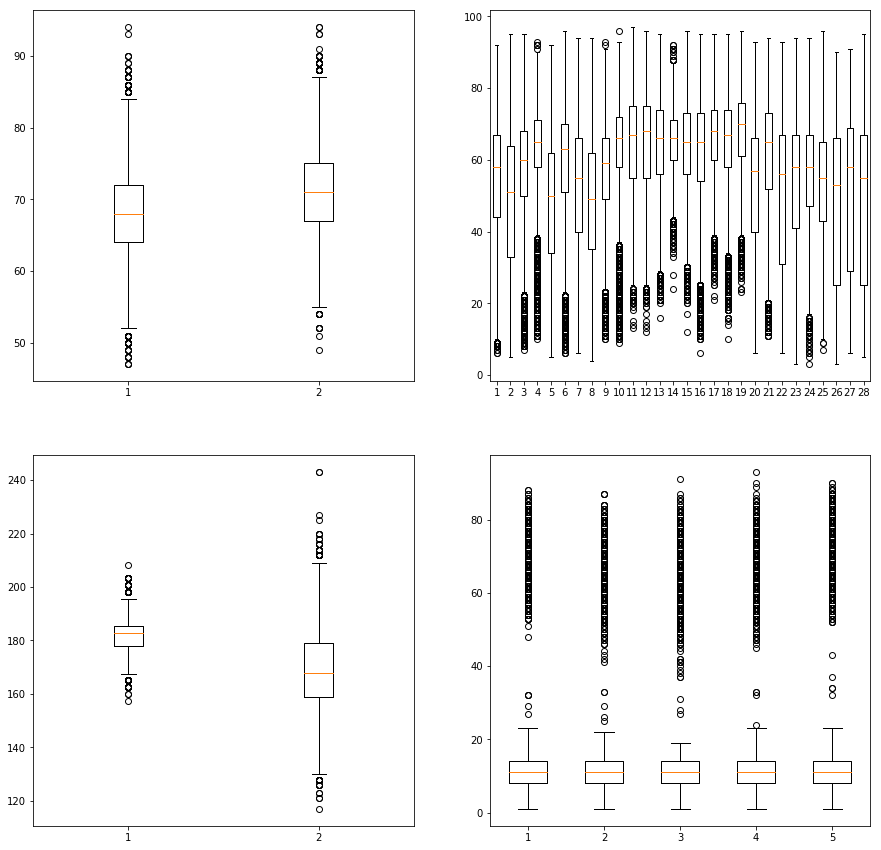

In [14]:
fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (15, 15))
axes[0,0].boxplot(np.array(player_merged[set1]))
axes[0,1].boxplot(np.array(player_merged[set2]))
axes[1,0].boxplot(np.array(player_merged[set4]))
axes[1,1].boxplot(np.array(player_merged[set3]))
fig.subplots_adjust(hspace = 0.2)

plt.show()

The bottom right boxplot shows the attributes related to goalkeepers. On this analysis I won't be dealing with goalkeepers information, thus I'll drop those features.

In [15]:
player_merged.info()
player_merged = player_merged.drop(set3, axis = 1)
player_merged.info()
player_merged.describe()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10407 entries, 102482 to 86924
Data columns (total 48 columns):
id_x                    10407 non-null int64
player_fifa_api_id_x    10407 non-null int64
player_api_id           10407 non-null int64
date                    10407 non-null object
overall_rating          10407 non-null float64
potential               10407 non-null float64
preferred_foot          10407 non-null object
attacking_work_rate     10407 non-null object
defensive_work_rate     10407 non-null object
crossing                10407 non-null float64
finishing               10407 non-null float64
heading_accuracy        10407 non-null float64
short_passing           10407 non-null float64
volleys                 10407 non-null float64
dribbling               10407 non-null float64
curve                   10407 non-null float64
free_kick_accuracy      10407 non-null float64
long_passing            10407 non-null float64
ball_control            10407 non-null float64
acc

,id_x,player_fifa_api_id_x,player_api_id,overall_rating,potential,crossing,finishing,heading_accuracy,short_passing,volleys,...,positioning,vision,penalties,marking,standing_tackle,sliding_tackle,id_y,player_fifa_api_id_y,height,weight
count,10407.000000,10407.000000,10407.000000,10407.000000,10407.000000,10407.000000,10407.000000,10407.00000,10407.000000,10407.000000,...,10407.000000,10407.000000,10407.000000,10407.000000,10407.000000,10407.000000,10407.000000,10407.000000,10407.000000,10407.000000
mean,92339.527530,169238.058903,163008.472855,68.157875,71.027578,54.172768,48.285289,56.82137,61.995292,47.884309,...,53.109638,56.286346,53.178245,47.139521,50.658307,48.184876,5541.826079,169219.893149,181.884209,168.407226
std,53127.667096,55738.661614,163088.606594,6.264016,6.201987,17.548930,19.014258,16.72997,13.775815,17.992563,...,19.079952,14.563317,15.931402,21.649159,21.791741,21.704373,3192.499249,55747.124996,6.384225,15.024889
min,1.000000,2.000000,2625.000000,47.000000,49.000000,6.000000,5.000000,7.00000,10.000000,5.000000,...,3.000000,3.000000,7.000000,3.000000,6.000000,5.000000,1.000000,2.000000,157.480000,117.000000
25%,46483.500000,157208.500000,36804.000000,64.000000,67.000000,44.000000,33.000000,50.00000,58.000000,34.000000,...,41.000000,47.000000,43.000000,25.000000,29.000000,25.000000,2787.500000,157098.500000,177.800000,159.000000
50%,92176.000000,186753.000000,106286.000000,68.000000,71.000000,58.000000,51.000000,60.00000,65.000000,50.000000,...,58.000000,58.000000,55.000000,53.000000,58.000000,55.000000,5547.000000,186724.000000,182.880000,168.000000
75%,138733.500000,204621.500000,229768.500000,72.000000,75.000000,67.000000,64.000000,68.00000,71.000000,62.000000,...,67.000000,67.000000,65.000000,66.000000,69.000000,67.000000,8298.500000,204617.000000,185.420000,179.000000
max,183969.000000,234141.000000,750584.000000,94.000000,94.000000,92.000000,95.000000,95.00000,93.000000,92.000000,...,94.000000,94.000000,96.000000,90.000000,91.000000,95.000000,11075.000000,234141.000000,208.280000,243.000000


Here I took the 40 best players instead of 20. In the future I'd like to inspect what makes a top player.

In [16]:
top40 = player_merged.iloc[:40, :]

In [17]:
top40.head()

,id_x,player_fifa_api_id_x,player_api_id,date,overall_rating,potential,preferred_foot,attacking_work_rate,defensive_work_rate,crossing,...,penalties,marking,standing_tackle,sliding_tackle,id_y,player_name,player_fifa_api_id_y,birthday,height,weight
102482,102483,158023,30981,2015-12-17 00:00:00,94.0,94.0,left,medium,low,80.0,...,74.0,13.0,23.0,21.0,6176,Lionel Messi,158023,1987-06-24 00:00:00,170.18,159
33330,33331,20801,30893,2015-10-16 00:00:00,93.0,93.0,right,high,low,82.0,...,85.0,22.0,31.0,23.0,1995,Cristiano Ronaldo,20801,1985-02-05 00:00:00,185.42,176
131464,131465,190871,19533,2016-02-04 00:00:00,90.0,94.0,right,high,medium,72.0,...,81.0,21.0,24.0,33.0,7867,Neymar,190871,1992-02-05 00:00:00,175.26,150
105983,105984,176580,40636,2015-10-16 00:00:00,90.0,90.0,right,high,medium,77.0,...,85.0,30.0,45.0,38.0,6377,Luis Suarez,176580,1987-01-24 00:00:00,182.88,187
109033,109034,167495,27299,2016-04-21 00:00:00,90.0,90.0,right,medium,medium,15.0,...,37.0,10.0,10.0,11.0,6556,Manuel Neuer,167495,1986-03-27 00:00:00,193.04,203


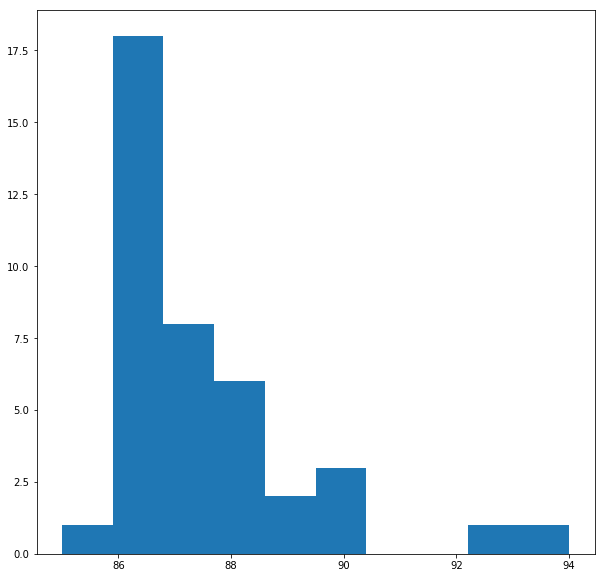

In [18]:
plt.figure(figsize = (10,10))
plt.hist(top40['overall_rating'])
plt.show()

In [19]:
top40_corr = top40.corr()

For the moment I'll working only with matplotlib. My intention with that is to guarantee that at least matplotlib I can understand and make it work properly.

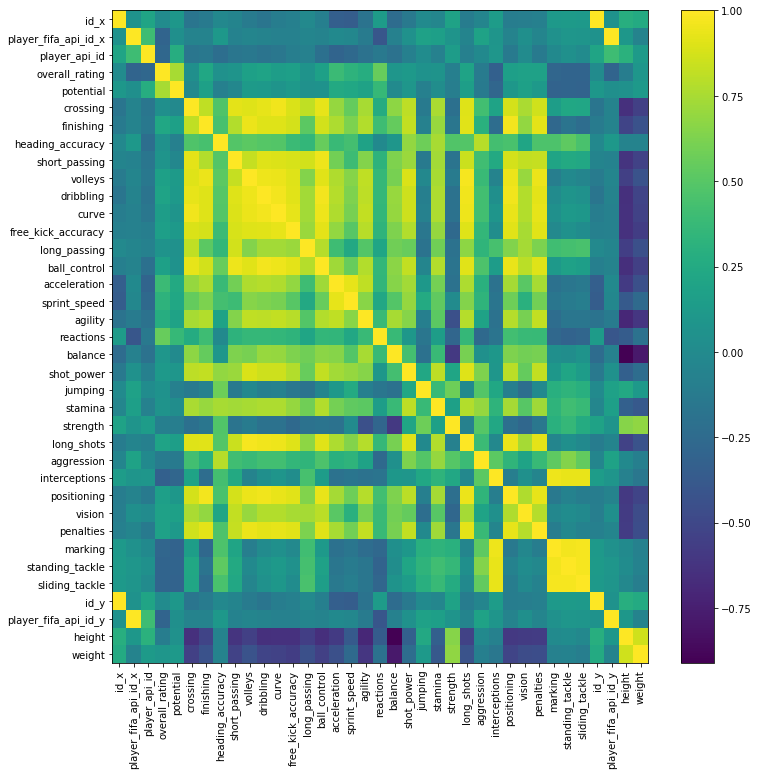

In [20]:
plt.figure(figsize = (12, 12))
plt.imshow(top40_corr, interpolation = 'none', aspect = 'auto')

plt.colorbar()
plt.xticks(range(len(top40_corr)), top40_corr.columns, rotation = 'vertical')
plt.yticks(range(len(top40_corr)), top40_corr.columns)
plt.show()

In [21]:
M, N = top40_corr.shape
U, s, Vh = linalg.svd(top40_corr)
Sig = linalg.diagsvd(s, M, N)
